In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import glob
import re
from matplotlib import colors
import collections
import matplotlib
import scipy.stats as stats
import math
import lmfit
import pandas as pd
import os

#for event display
import sys
import EventDisplay
import matplotlib.colors as colors
from platform import python_version
print(python_version())

3.11.5


## Load in data

Loads in the data, break in the loop to only load the first 10 files - can be tuned to look at specific files. Notebook will crash if too much data is loaded - loading only hits and not waveforms is an option to reduce memory

In [2]:
runNumber = 2521
#f'../data/2025_LaserBall/WCTE_offline_R{run}S*P*.root'
file_pattern = "../WCTE_offline_R"+str(runNumber)+"S0P4.root"
file_list = glob.glob(file_pattern)
print (file_list)

def extract_p_number(file_name):
    match = re.search(r'P(\d+)\.root$', file_name)  # Extract number after 'P'
    return int(match.group(1)) if match else float('inf')  # Convert to int, default high if no match

file_list = sorted(file_list, key=extract_p_number)
# print(file_list)

all_events_list = []

# Loop over files and load data
for ifile, file_path in enumerate(file_list):
    if ifile>9:
        break
    print(f"Loading: {file_path}")
    
    with uproot.open(file_path) as root_file:
        tree = root_file["WCTEReadoutWindows"]
        #Entry start and stop used to fix number of events!
        events = tree.arrays(library="ak",entry_start=1, entry_stop=100)  # Load branches as awkward arrays
        all_events_list.append(events)  # Store in list

# Concatenate everything into a single awkward array
if all_events_list:
    all_events = ak.concatenate(all_events_list,axis=0)
    
print(f"Total events loaded: {len(all_events)}")
print(all_events[0].fields)
    
file_mPMT_card = []
file_mPMT_id = []
file_PMT_id = []
file_hits = []
file_charge = []
file_monitor_charge = []
file_monitor_waveforms = []

['../WCTE_offline_R2521S0P4.root']
Loading: ../WCTE_offline_R2521S0P4.root
Total events loaded: 99
['window_time', 'start_counter', 'run_id', 'sub_run_id', 'spill_counter', 'event_number', 'readout_number', 'trigger_types', 'trigger_times', 'led_gains', 'led_dacsettings', 'led_ids', 'led_card_ids', 'led_slot_numbers', 'led_event_types', 'led_types', 'led_sequence_numbers', 'led_counters', 'hit_mpmt_card_ids', 'hit_pmt_channel_ids', 'hit_mpmt_slot_ids', 'hit_pmt_position_ids', 'hit_pmt_charges', 'hit_pmt_times', 'pmt_waveform_mpmt_card_ids', 'pmt_waveform_pmt_channel_ids', 'pmt_waveform_mpmt_slot_ids', 'pmt_waveform_pmt_position_ids', 'pmt_waveform_times', 'pmt_waveforms', 'beamline_pmt_qdc_charges', 'beamline_pmt_tdc_times', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids']


In [3]:
def get_charges():
    #Implement the mPMT firmware method for charge collection, adding ~5 data points around peak
    for iev, event in enumerate(all_events):

        if iev%100==0:
            print("On event", iev)

        cards = np.array(event['pmt_waveform_mpmt_card_ids'])
        pmt = np.array(event['pmt_waveform_pmt_position_ids'])
        
        waveforms = np.array(event['pmt_waveforms'])  # shape: (n_cards, waveform_length)
        
        # Mask for valid cards
        wcte_mpmts = cards <= 125
        wcte_waveforms = waveforms[wcte_mpmts]
        # Count how many waveforms have a max > 30
        hit_mask = np.max(wcte_waveforms, axis=1) > 1
    
        charges = []
        mPMT_id = []
        mPMT_card = []
        PMT_id = []

        # Couldn't get hitmask for trigger board to work, just loop through everything and get card ID 131
        for mpmt, pmt, waveform in zip(event['pmt_waveform_mpmt_card_ids'], event['pmt_waveform_pmt_channel_ids'],event['pmt_waveforms']):
            if mpmt != 131:
                continue
            #Monitor PMT is on channel 16, ignore everything else
            if pmt != 16:
                continue
            
            max_idx = np.argmax(waveform)
            charge_sum = 0
            
            # Integrate charge in waveform over ~15 steps
            if ((max_idx > 3) and (max_idx < (len(waveform) - 12))):
                for step in range(-3,12,1):
                    charge_sum += waveform[max_idx + step]

            if(charge_sum < 10):
                charge_sum = -1
            file_monitor_charge.append(charge_sum)
            file_monitor_waveforms.append(waveform)
        
        # Get mPMT PMT waveforms and calculate charge around peak, matches mPMT firmware algorithm
        for card, slot, pmt, waveform in zip(event['pmt_waveform_mpmt_card_ids'][hit_mask],event['pmt_waveform_mpmt_slot_ids'][hit_mask],event['pmt_waveform_pmt_position_ids'][hit_mask],event['pmt_waveforms'][hit_mask]):
            max_idx = np.argmax(waveform)
            left = waveform[max_idx - 1] if max_idx > 0 else 0
            center = waveform[max_idx]
            right = waveform[max_idx + 1] if max_idx < len(waveform) - 1 else 0
            if left <0:
                left =0
            if right <0:
                right =0
            total_charge = left + center + right

            charges.append(total_charge)
            mPMT_id.append(slot)
            mPMT_card.append(card)
            PMT_id.append(pmt)
            
        file_charge.append(charges)
        file_mPMT_id.append(mPMT_id)
        file_mPMT_card.append(mPMT_card)
        file_PMT_id.append(PMT_id)
        

In [4]:
get_charges()

On event 0


Text(0, 0.5, 'Charge')

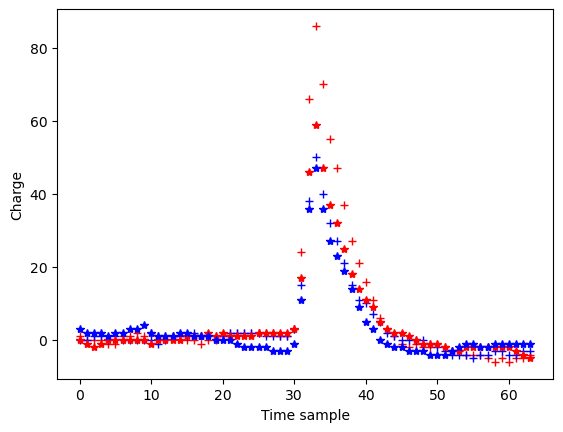

In [5]:
#plot some waveforms to check they look OK.
plt.plot(file_monitor_waveforms[0], 'r+')
plt.plot(file_monitor_waveforms[1], 'b+')
plt.plot(file_monitor_waveforms[2], 'r*')
plt.plot(file_monitor_waveforms[3], 'b*')
plt.xlabel("Time sample")
plt.ylabel("Charge")
#ax = plt.gca()
#ax.set_xlim([0, 50])
#ax.set_ylim([0, 4000])

In [6]:
#Read results of charge fits to get PMT gain
results = pd.read_pickle("./charge_fits")

In [7]:
# Convert PMT charge to pe using gains 
file_charge_pe = []
for i in range(len(file_charge)):
    charges = file_charge[i]
    mpmts = file_mPMT_id[i]
    cards = file_mPMT_card[i]
    pmts = file_PMT_id[i]
    for j in range(len(charges)):
        charge = charges[j]
        mpmt = mpmts[j]
        pmt = pmts[j]
        card = cards[j]
        
        temp = results[(results['card'] == int(card)) & (results['channel'] == float(pmt))]
        if(len(temp)):
            q1 = temp['Q1'].item()
        else:
            q1 = 999999999.9
        charge_pe = charge/q1 

        if(charge_pe > 100.0):
            charge_pe = -1
            
        if i%100==0 and j % 100==0:
            print("charge =", charge)
            print("q1 =", q1)
            print("PMT charge =",charge_pe,"pe")
    
        file_charge_pe.append(charge_pe)
    

charge = 72.0
q1 = 133.70343860506688
PMT charge = 0.5385052228362918 pe
charge = 91.0
q1 = 135.97451154075068
PMT charge = 0.6692430733441384 pe
charge = 119.0
q1 = 145.00097998567017
PMT charge = 0.8206841085609232 pe
charge = 123.0
q1 = 144.58374244780617
PMT charge = 0.8507180538946295 pe
charge = 5.0
q1 = 139.07553352103093
PMT charge = 0.03595168663684402 pe
charge = 5.0
q1 = 999999999.9
PMT charge = 5.0000000005e-09 pe
charge = 1.0
q1 = 143.222584365182
PMT charge = 0.0069821390560182075 pe
charge = 4.0
q1 = 147.20641657352226
PMT charge = 0.02717272856106921 pe
charge = 1.0
q1 = 140.95495866314693
PMT charge = 0.007094464852348986 pe


(1, 2000)

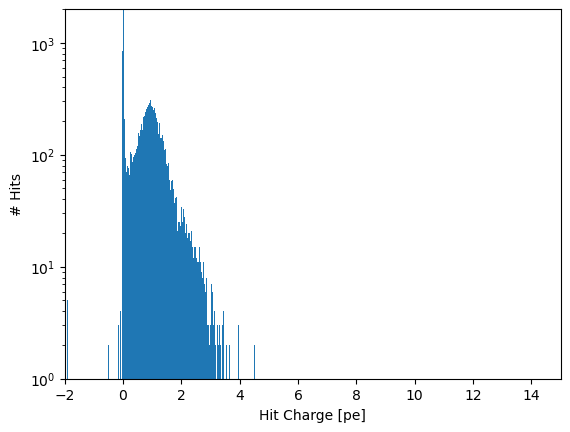

In [8]:
#Plot PMT charges in PE
plt.hist(file_charge_pe, bins = 1100)
plt.yscale("log")
plt.xlabel("Hit Charge [pe]")
plt.xlabel("Hit Charge [pe]")
plt.ylabel("# Hits")
ax = plt.gca()
ax.set_xlim([-2, 15])
ax.set_ylim([1, 2000])

99


(0.0, 2500.0)

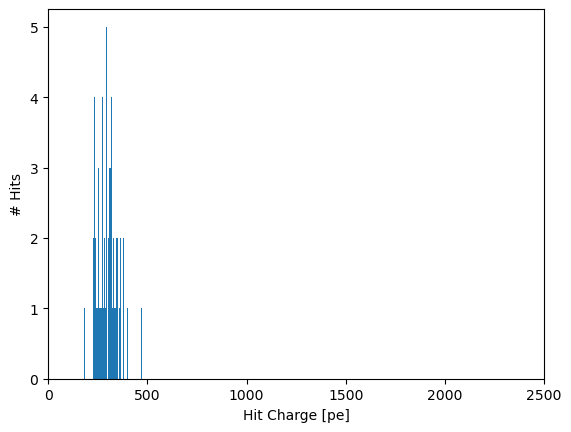

In [9]:
#Plot monitor PMT charge in ADC
plt.hist(file_monitor_charge, bins = 100)
print(len(file_monitor_charge))
#plt.yscale("log")
plt.xlabel("Hit Charge [pe]")
plt.xlabel("Hit Charge [pe]")
plt.ylabel("# Hits")
ax = plt.gca()
ax.set_xlim([0, 2500])
#ax.set_ylim([0, 4])

## Load event display of N events

In [10]:
#Convert PMT ID and mPMT ID to event display enumerator
# Create list of charges aligned with list of PMT IDs
mpmt_ids_np = np.concatenate([np.array(xi) for xi in file_mPMT_id])
pmt_ids_np = np.concatenate([np.array(xi) for xi in file_PMT_id])
charge_np = np.concatenate([np.array(xi) for xi in file_charge])
charge_pe_np = np.array(file_charge_pe)
unique = []
for index in range(len(mpmt_ids_np)):
    y = mpmt_ids_np[index]
    z = pmt_ids_np[index]
    unique.append(y*19 + z)
    
unique_np = np.array(unique)

(2014,)


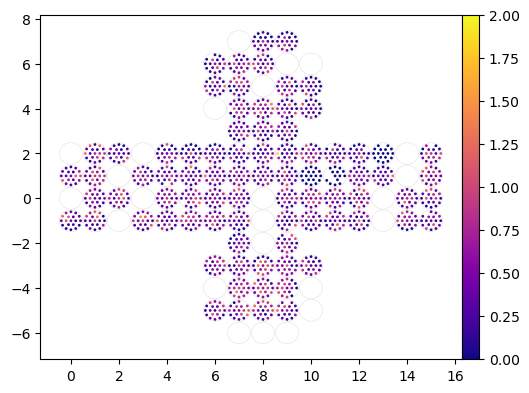

In [11]:
eventDisplay = EventDisplay.EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

#process data has a sum_data option set to true by default, 
# if set to false it will only plot the smallest quantity for each PMT e.g. time 
#Average_Data will attempt to average the data above threshold

ev_disp_data = eventDisplay.process_data(unique_np,charge_pe_np,sum_data=True, average_data=True)

# eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.Normalize(), style= "dark_background")
eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.Normalize(vmin= 0, vmax = 2), style="")

plt.show(block=False)
plt.style.use('default') 